# Sizing a mosfet using gm/Id method

This is an example you can use to calculate mosfet size in Sky130 for given design parameters. You can change the parameters below and recalculate.

In [1]:
%pylab inline
import numpy as np
from scipy.interpolate import interp1d
import pint
ureg = pint.UnitRegistry()  # convenient unit conversions

Populating the interactive namespace from numpy and matplotlib


First we'll setup the design parameters. The mosfet length and width will need to be one of the bin values for the selected mosfet model.

In [2]:
A_v = np.abs(-2)       # voltage gain at DC
I_d = 0.5 * ureg.mA    # maximum drain current
f_c = 500 * ureg.MHz   # corner (3dB) frequency
C_L = 1 * ureg.pF      # Load capacitance

# simulation parameters
sim_L = 0.15 * ureg.um # target mosfet length
sim_W = 1 * ureg.um    # calculations are independent of width but we need to have a matching bin value for the initial simulations
sim_Vdd = 1.8 * ureg.V

First we calculate the load resistance.

\begin{align}
R_L &= \frac{1}{2 * \pi * f_c * C_L}
\end{align}

In [3]:
R_L = 1 / (2 * 3.1415 * f_c * C_L)
R_L = R_L.to(ureg.ohms)
print(R_L)

318.3192742320548 ohm


Next we calculate transconductance.
\begin{align}
g_m &= \frac{A_v}{R_L}
\end{align}

In [4]:
g_m = A_v / R_L
g_m = g_m.to(ureg.mS)
print(f'gm={g_m}')

gm=6.2829999999999995 millisiemens


Now we need to generate the gm/Id graphs we'll need to determine the remaining values. These can be pre-generated and loaded or calculate here. We'll load them from an hdf5 file generated with _gen_gm_id_plots.py_.

In [5]:
import h5py
f = h5py.File('gm_id_01v8/sky130_fd_pr__nfet_01v8__data.h5', 'r')
bin_idx = 4
assert(f['bins'][bin_idx][1] - sim_L.magnitude < 0.00001)  # index of the W=1 L=0.15 bin in the repo data.

vsweep=f['vsweep'][bin_idx] * ureg.V
gm_id = (f['gm'][bin_idx] * ureg.mS) / (f['id'][bin_idx] * ureg.A)
id_W = (f['id'][bin_idx] * ureg.A / sim_W)

We could just look for the $\frac{I_d}{W}$ on the graph, but we've got the data and data interpolation tools, so we can calculate exactly. We'll figure out the value and plot it on the graph as a visual validation.

In [6]:
i_id_w__gm_id = interp1d(gm_id.magnitude, id_W.magnitude)
id_interp = i_id_w__gm_id(g_m.magnitude) * id_W.units
print(f'Id={id_interp.to(ureg.uA / ureg.um)}')

Id=63.30221617728767 microampere / micrometer


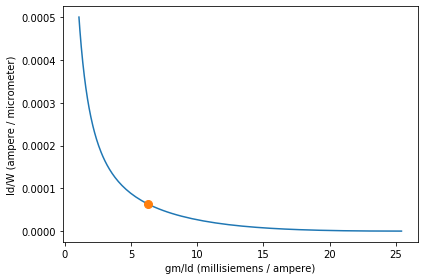

In [7]:
fig = figure()
id_w__gm_id = fig.subplots(1, 1)
id_w__gm_id.plot(gm_id.magnitude, id_W.magnitude)
id_w__gm_id.axes.set_xlabel(f'gm/Id ({gm_id.units})')
id_w__gm_id.axes.set_ylabel(f'Id/W ({id_W.units})')
id_w__gm_id.plot(g_m.magnitude, id_interp.magnitude, 'o', markersize=8)
fig.tight_layout()

This allows us to calculate the transistor width.
\begin{align}
W &= \frac{I_d}{\frac{I_d}{W}}
\end{align}

In [8]:
W = I_d / id_interp
W = W.to(ureg.um)
print(f'W={W}')

W=7.898617618689249 micrometer


Next we determine the gate bias using the same interpolation technique as above.

Vbias=0.9395423670496599 volt


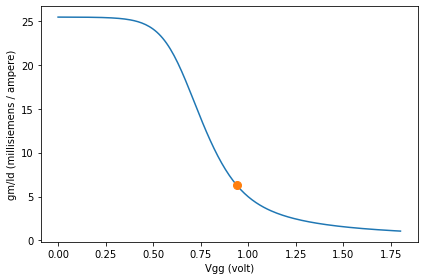

In [9]:
i_vgg__gm_id = interp1d(gm_id.magnitude, vsweep.magnitude)
vbias_interp = i_vgg__gm_id(g_m.magnitude) * vsweep.units
print(f'Vbias={vbias_interp}')
fig = figure()
gm_id__vgg = fig.subplots(1, 1)
gm_id__vgg.plot(vsweep.magnitude, gm_id.magnitude)
gm_id__vgg.axes.set_xlabel(f'Vgg ({vsweep.units})')
gm_id__vgg.axes.set_ylabel(f'gm/Id ({gm_id.units})')
gm_id__vgg.plot(vbias_interp.magnitude, g_m.magnitude, 'o', markersize=8)
fig.tight_layout()